**1. Setup the environment variables**

In [1]:
%%time
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/opt/spark"

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 26.2 µs


In [3]:
%%time
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions 
from pyspark.sql.functions import col, avg
import seaborn as sns
spark = SparkSession.builder.appName("Lab6").master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


CPU times: user 696 ms, sys: 277 ms, total: 973 ms
Wall time: 6 s


In [4]:
# Code to calculate total time
import time
start_time = time.time()

**2. Data Preparation**

In [5]:
%%time
file_loc = "lab6/listings.csv"
airbnb_schema = spark.read.csv(file_loc, inferSchema=True, header=True, multiLine=True, quote='"', escape='"')

CPU times: user 6.49 ms, sys: 717 µs, total: 7.21 ms
Wall time: 5.6 s


In [6]:
%%time
airbnb_schema.show()
print("Total number of records in the dataset - ", airbnb_schema.count())

24/04/04 09:14:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+--------------------+--------------+------------+---------------+--------------------+-----------+---------------------+--------------------+-------+--------------------+--------------+----------+----------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+-----------------+------------------+--------------------+---------------+------------+---------+--------------+--------+----+---------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------+-

Total number of records in the dataset -  18321
CPU times: user 5.8 ms, sys: 6.04 ms, total: 11.8 ms
Wall time: 5.19 s


**3. Print the dataset schema to understand the type of data we are dealing with.**

In [7]:
%%time
airbnb_schema.printSchema()

root
 |-- id: long (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: long (nullable = true)
 |-- last_scraped: date (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_count: int

In [8]:
%%time
# Check for count of null values in each column of the dataframe.
print("Count of null values for each feature: ")
for col in airbnb_schema.columns:
  print(col, ": ", airbnb_schema.where(airbnb_schema[col].isNull()).count())

Count of null values for each feature: 


id :  0


listing_url :  0
scrape_id :  0
last_scraped :  0
source :  0
name :  0
description :  18321
neighborhood_overview :  8273
picture_url :  0
host_id :  0
host_url :  0
host_name :  2
host_since :  2
host_location :  4193
host_about :  6759
host_response_time :  2
host_response_rate :  2
host_acceptance_rate :  2
host_is_superhost :  78
host_thumbnail_url :  2
host_picture_url :  2
host_neighbourhood :  8958
host_listings_count :  2
host_total_listings_count :  2
host_verifications :  0
host_has_profile_pic :  2
host_identity_verified :  2
neighbourhood :  8273
neighbourhood_cleansed :  0
neighbourhood_group_cleansed :  0
latitude :  0
longitude :  0
property_type :  0
room_type :  0
accommodates :  0
bathrooms :  18321
bathrooms_text :  10
bedrooms :  18319
beds :  317
amenities :  0
price :  2265
minimum_nights :  0


maximum_nights :  0


minimum_minimum_nights :  0


maximum_minimum_nights :  0


minimum_maximum_nights :  0
maximum_maximum_nights :  0
minimum_nights_avg_ntm :  0
maximum_nights_avg_ntm :  0
calendar_updated :  18321
has_availability :  2265
availability_30 :  0
availability_60 :  0
availability_90 :  0
availability_365 :  0
calendar_last_scraped :  0
number_of_reviews :  0
number_of_reviews_ltm :  0
number_of_reviews_l30d :  0
first_review :  4369
last_review :  4369
review_scores_rating :  4362
review_scores_accuracy :  4365
review_scores_cleanliness :  4365
review_scores_checkin :  4369
review_scores_communication :  4363
review_scores_location :  4370
review_scores_value :  4369
license :  5917
instant_bookable :  0
calculated_host_listings_count :  0
calculated_host_listings_count_entire_homes :  0
calculated_host_listings_count_private_rooms :  0
calculated_host_listings_count_shared_rooms :  0
reviews_per_month :  4369
CPU times: user 158 ms, sys: 41.5 ms, total: 200 ms
Wall time: 41.1 s


*We see that there are a lot of nulls by observing the first 20 rows of the dataset above. So, we checked the count of null values in each column of the dataset.*

**3. Drop some columns which are not important for analyzing the data.**

In [9]:
%%time
airbnb_schema = airbnb_schema.select("name", "host_id", "neighbourhood_group_cleansed", "neighbourhood_cleansed", "latitude", "longitude", "room_type", "price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365")

CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 155 ms


In [10]:
%%time
airbnb_schema.printSchema()

root
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- neighbourhood_group_cleansed: string (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)

CPU times: user 0 ns, sys: 971 µs, total: 971 µs
Wall time: 2.3 ms


The column 'price' has the data type of string as we saw with printSchema(). Each data instance of the column has the format of '%d$'. We first have to convert the data type of the column to int before further analysis.

In [11]:
%%time
data_type = airbnb_schema.select('price').dtypes[0][1]
print(data_type)

string
CPU times: user 1.73 ms, sys: 529 µs, total: 2.26 ms
Wall time: 12.6 ms


In [12]:
%%time
from pyspark.sql.functions import *
airbnb_schema = airbnb_schema.withColumn('price', regexp_replace('price', '\\$', ''))
airbnb_schema.show()
data_type = airbnb_schema.select('price').dtypes[0][1]
print(data_type)

+--------------------+-------+----------------------------+----------------------+-----------------+------------------+---------------+------+--------------+-----------------+-----------------+------------------------------+----------------+
|                name|host_id|neighbourhood_group_cleansed|neighbourhood_cleansed|         latitude|         longitude|      room_type| price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+--------------------+-------+----------------------------+----------------------+-----------------+------------------+---------------+------+--------------+-----------------+-----------------+------------------------------+----------------+
|Rental unit in 08...|  65623|                    Eixample|  la Dreta de l'Eix...|         41.39939|           2.17044|Entire home/apt|140.00|             5|               26|             0.16|                             1|              32|
|Rental unit in Ba...|  71615|  

In [13]:
%%time
# Convert to int and check
airbnb_schema = airbnb_schema.withColumn("price", col("price").cast("int"))
airbnb_schema.show()
data_type = airbnb_schema.select('price').dtypes[0][1]
print(data_type)

+--------------------+-------+----------------------------+----------------------+-----------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|                name|host_id|neighbourhood_group_cleansed|neighbourhood_cleansed|         latitude|         longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+--------------------+-------+----------------------------+----------------------+-----------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|Rental unit in 08...|  65623|                    Eixample|  la Dreta de l'Eix...|         41.39939|           2.17044|Entire home/apt|  140|             5|               26|             0.16|                             1|              32|
|Rental unit in Ba...|  71615|      

**4. Clean the null values from review_per_month and price column . We will replace all the null values with zero as "null" reviews_per_month and "null" price.**

In [14]:
%%time
airbnb_schema = airbnb_schema.na.fill(0, ["reviews_per_month"])
print("Number of nulls after cleanup in column 'reviews_per_month' - ")
airbnb_schema.where(airbnb_schema['reviews_per_month'].isNull()).count()

Number of nulls after cleanup in column 'reviews_per_month' - 
CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 136 ms


0

In [15]:
%%time
airbnb_schema = airbnb_schema.na.fill(0, ["price"])
print("Number of nulls after cleanup in column 'price' - ")
airbnb_schema.where(airbnb_schema['price'].isNull()).count()

Number of nulls after cleanup in column 'price' - 
CPU times: user 4.27 ms, sys: 0 ns, total: 4.27 ms
Wall time: 73.6 ms


0

**5. Analyze the host id field.** 

Count the number of listings for each host ID.

Sort the results in descending order, so we can see the top 20 hosts.

In [16]:
%%time
host_id_schema = airbnb_schema.groupBy(airbnb_schema["host_id"]).count()
host_id_schema.orderBy(host_id_schema["count"].desc()).show()

+---------+-----+
|  host_id|count|
+---------+-----+
|346367515|  318|
|357946540|  271|
| 32037490|  231|
|  4459553|  179|
|  1447144|  174|
|461820156|  150|
|265193861|  148|
|  1391607|  142|
|   299462|  141|
| 36607755|  136|
|158023606|  131|
|221480824|  105|
|447375626|   99|
|   396363|   96|
| 47171261|   79|
|  1503151|   70|
| 33278356|   70|
|130223809|   70|
|  9400556|   52|
|  3556337|   51|
+---------+-----+
only showing top 20 rows

CPU times: user 4.25 ms, sys: 2.98 ms, total: 7.23 ms
Wall time: 911 ms


*The above analysis shows that the top host (host_id = 346367515) has 318 listings and also there is a good spread in the number of listings with each host.*

*We can confirm this finding by checking the 'calculated_host_listings_count' column which has a maximum value of 318.*

**6. Check the max value from calculated_host_listings_count column**

In [17]:
%%time
from pyspark.sql import functions as F
# Check the max value from calculated_host_listings_count column
airbnb_schema.agg(F.max(airbnb_schema["calculated_host_listings_count"])).show()

+-----------------------------------+
|max(calculated_host_listings_count)|
+-----------------------------------+
|                                318|
+-----------------------------------+

CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 543 ms


**7. Counting the number of unique listings:**

There are 6256 unique listings in the dataset.

In [18]:
%%time
airbnb_schema.select("name").distinct().count()

CPU times: user 2.98 ms, sys: 0 ns, total: 2.98 ms
Wall time: 745 ms


6256

**8. Distinct neighbourhood group count**

In [19]:
%%time
airbnb_schema.select("neighbourhood_group_cleansed").distinct().count()

CPU times: user 904 µs, sys: 2.53 ms, total: 3.43 ms
Wall time: 513 ms


10

**9. Distinct neighbourhood group**

In [20]:
%%time
neighbourhood_group_data = airbnb_schema.groupby("neighbourhood_group_cleansed").count()
neighbourhood_group_data.show()

+----------------------------+-----+
|neighbourhood_group_cleansed|count|
+----------------------------+-----+
|                      Gràcia| 1571|
|                  Sant Martí| 1639|
|              Horta-Guinardó|  525|
|                   Les Corts|  369|
|              Sants-Montjuïc| 1902|
|                  Nou Barris|  210|
|         Sarrià-Sant Gervasi|  894|
|                    Eixample| 6575|
|                 Sant Andreu|  279|
|                Ciutat Vella| 4357|
+----------------------------+-----+

CPU times: user 0 ns, sys: 2.77 ms, total: 2.77 ms
Wall time: 549 ms


**10. Showing the above data as a pie chart to understand the division clearly.**

CPU times: user 56.3 ms, sys: 16 ms, total: 72.3 ms
Wall time: 565 ms


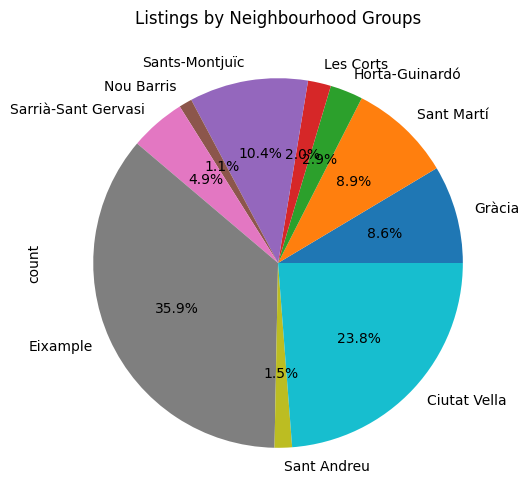

In [21]:
%%time
import pandas as pd
neighbourhood_group_data_pd = neighbourhood_group_data.toPandas()
neighbourhood_group_data_pd.index = neighbourhood_group_data_pd['neighbourhood_group_cleansed']
plt = neighbourhood_group_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Neighbourhood Groups', figsize=(16,6))


**11. Distinct neighbourhood count**

In [22]:
%%time
airbnb_schema.select("neighbourhood_cleansed").distinct().count()

CPU times: user 16.3 ms, sys: 1.12 ms, total: 17.4 ms
Wall time: 466 ms


71

**12. Distinct neighbourhood**

In [23]:
%%time
airbnb_schema.groupby("neighbourhood_cleansed").count().show()

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|           el Poblenou|  421|
|  el Besòs i el Mar...|  111|
|     la Vila de Gràcia| 1066|
|          la Guineueta|   10|
|          la Teixonera|   26|
|  la Dreta de l'Eix...| 2239|
|        el Barri Gòtic| 1282|
|           el Guinardó|  151|
|              Vallbona|    1|
|             Canyelles|    1|
|  Provençals del Po...|   83|
|   la Verneda i la Pau|   45|
|  Vilapicina i la T...|   64|
|  l'Antiga Esquerra...| 1062|
|                 Navas|   76|
|     la Marina de Port|   58|
|                Sarrià|   56|
|  la Marina del Pra...|    6|
|            Torre Baró|    5|
|      la Trinitat Nova|    5|
+----------------------+-----+
only showing top 20 rows

CPU times: user 2.85 ms, sys: 99 µs, total: 2.95 ms
Wall time: 541 ms


In [24]:
%%time
from pyspark.sql import functions
from pyspark.sql.functions import col, avg
airbnb_schema.groupby("neighbourhood_cleansed").count().sort(col("count").desc()).show(5)

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  la Dreta de l'Eix...| 2239|
|              el Raval| 1474|
|        el Barri Gòtic| 1282|
|  Sant Pere, Santa ...| 1179|
|     la Vila de Gràcia| 1066|
+----------------------+-----+
only showing top 5 rows

CPU times: user 3.61 ms, sys: 326 µs, total: 3.94 ms
Wall time: 540 ms


**13. Analysis of availability of apartments.**

In [25]:
%%time
avail_df = airbnb_schema.groupby("availability_365").count().sort(col("availability_365").asc())
avail_df.show()

+----------------+-----+
|availability_365|count|
+----------------+-----+
|               0| 4180|
|               1|   50|
|               2|   28|
|               3|   22|
|               4|   24|
|               5|   23|
|               6|   18|
|               7|   65|
|               8|   34|
|               9|   35|
|              10|   24|
|              11|   25|
|              12|   35|
|              13|   38|
|              14|   29|
|              15|   34|
|              16|   27|
|              17|   43|
|              18|   46|
|              19|   20|
+----------------+-----+
only showing top 20 rows

CPU times: user 973 µs, sys: 3.24 ms, total: 4.21 ms
Wall time: 516 ms


**14. Distinct host id**

In [26]:
%%time
airbnb_schema.select("host_id").distinct().count()

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 622 ms


7016

**15. Number of apartments under different room type**

Find all different room types

In [27]:
%%time
unique_rooms = airbnb_schema.select("room_type").distinct()
unique_rooms.show()

+---------------+
|      room_type|
+---------------+
|    Shared room|
|     Hotel room|
|Entire home/apt|
|   Private room|
+---------------+

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 552 ms


In [28]:
%%time
# Number of apartments under different room type
room_type_data = airbnb_schema.where(airbnb_schema.room_type.isin("Private room","Entire home/apt","Shared room", "Hotel room")).groupBy(airbnb_schema["room_type"]).count().sort(col("room_type").desc())
room_type_data.show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  161|
|   Private room| 7275|
|     Hotel room|  134|
|Entire home/apt|10751|
+---------------+-----+

CPU times: user 6.87 ms, sys: 790 µs, total: 7.67 ms
Wall time: 653 ms


**16. Showing a general preference based on the room types. As we can see, most people prefer an Entire home/apt followed by Private Room and very few Shared rooms**

CPU times: user 30.5 ms, sys: 3.9 ms, total: 34.4 ms
Wall time: 695 ms


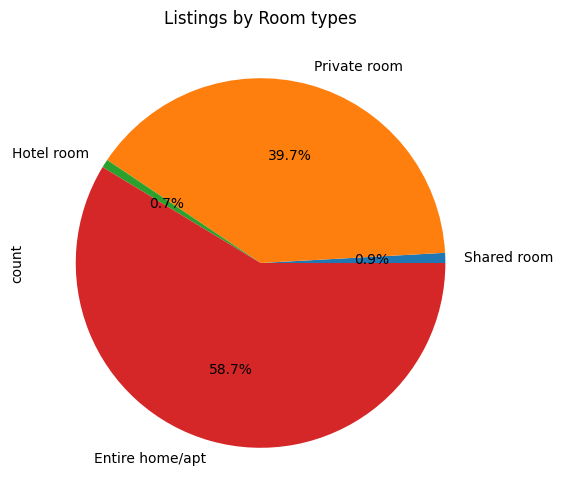

In [29]:
%%time
import pandas as pd
room_type_data_pd = room_type_data.toPandas()
room_type_data_pd.index = room_type_data_pd['room_type']
plt = room_type_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Room types', figsize=(16,6))

**17. Combining room_type with neighbourhoodt**

In [30]:
%%time
neigh_room_type_schema = airbnb_schema.select(airbnb_schema["neighbourhood_cleansed"], airbnb_schema["room_type"]).show()

+----------------------+---------------+
|neighbourhood_cleansed|      room_type|
+----------------------+---------------+
|  la Dreta de l'Eix...|Entire home/apt|
|    la Sagrada Família|Entire home/apt|
|  Diagonal Mar i el...|Entire home/apt|
|  l'Antiga Esquerra...|   Private room|
|  el Besòs i el Mar...|Entire home/apt|
|     la Vila de Gràcia|Entire home/apt|
|  el Camp d'en Gras...|Entire home/apt|
|          el Poble Sec|Entire home/apt|
|     la Vila de Gràcia|Entire home/apt|
|        el Barri Gòtic|Entire home/apt|
|          el Poble Sec|   Private room|
|        el Barri Gòtic|Entire home/apt|
|        la Barceloneta|   Private room|
|                 Sants|Entire home/apt|
|         el Fort Pienc|Entire home/apt|
|  la Dreta de l'Eix...|Entire home/apt|
|  el Camp d'en Gras...|Entire home/apt|
|  Sant Pere, Santa ...|Entire home/apt|
|  el Camp d'en Gras...|Entire home/apt|
|    la Sagrada Família|Entire home/apt|
+----------------------+---------------+
only showing top

**18. Below table shows room type by neighbourhood group**

In [31]:
%%time
# room type by neighbourhood group.
neighbourhoodgrp_roomtype = airbnb_schema.select(airbnb_schema["neighbourhood_group_cleansed"], airbnb_schema["room_type"]).groupBy("neighbourhood_group_cleansed", "room_type").count()
neighbourhoodgrp_roomtype.show()

+----------------------------+---------------+-----+
|neighbourhood_group_cleansed|      room_type|count|
+----------------------------+---------------+-----+
|                Ciutat Vella|     Hotel room|   25|
|                    Eixample|     Hotel room|   84|
|                   Les Corts|    Shared room|    5|
|                Ciutat Vella|Entire home/apt| 2343|
|                    Eixample|    Shared room|   77|
|                 Sant Andreu|   Private room|  153|
|                Ciutat Vella|   Private room| 1981|
|              Sants-Montjuïc|    Shared room|   16|
|                  Sant Martí|    Shared room|   17|
|              Sants-Montjuïc|   Private room|  804|
|                 Sant Andreu|Entire home/apt|  122|
|                  Sant Martí|   Private room|  621|
|         Sarrià-Sant Gervasi|     Hotel room|    1|
|                Ciutat Vella|    Shared room|    8|
|                      Gràcia|Entire home/apt|  997|
|                  Nou Barris|Entire home/apt|

**19. Showing the distribution of room types based on the neighbourhood group. From this we can get an idea of what room type are most popular in respective neighbourhood group. This is very important data for someone who would like to setup a new listing or update an existing one.**

CPU times: user 85.6 ms, sys: 5.73 ms, total: 91.3 ms
Wall time: 587 ms


<Axes: xlabel='neighbourhood_group_cleansed'>

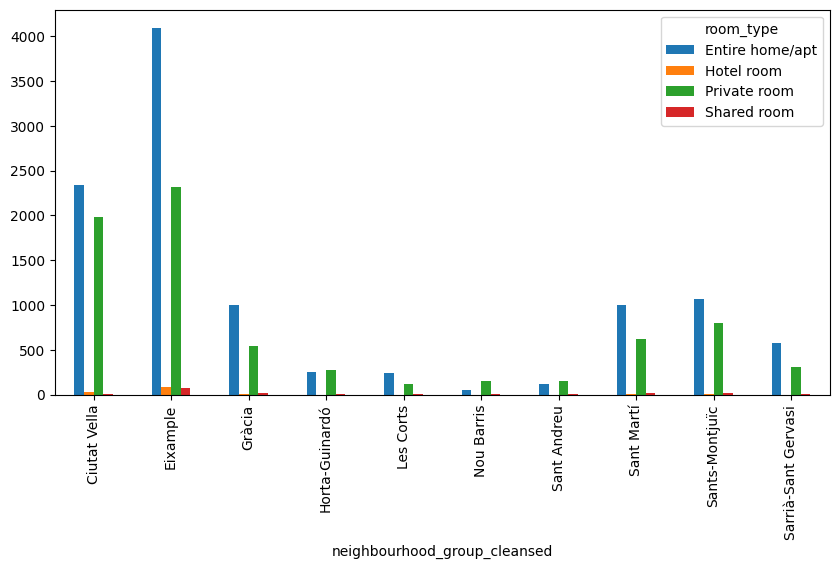

In [32]:
%%time
import pandas as pd
neighbourhoodgrp_roomtype_pd = neighbourhoodgrp_roomtype.toPandas()
pd.pivot_table(neighbourhoodgrp_roomtype_pd, index='neighbourhood_group_cleansed', columns='room_type', values='count').plot.bar(figsize=(10,5))


**20. Combining neighbourhood with neighbourhood group**

In [33]:
%%time
nei_group_nei_schema = airbnb_schema.select(airbnb_schema["neighbourhood_group_cleansed"], airbnb_schema["neighbourhood_cleansed"])
nei_group_nei_schema.sort(col("neighbourhood_group_cleansed").desc()).show()

+----------------------------+----------------------+
|neighbourhood_group_cleansed|neighbourhood_cleansed|
+----------------------------+----------------------+
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|                Sarrià|
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  el Putxet i el Farró|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  Sant Gervasi - Ga...|
|         Sarrià-Sant Gervasi|  Vallvidrera, el T...|
|         Sarrià-Sant Gervas

**21. Find the popular neighbourhood groups:**

Popular neighbourhood_groups are Eixample, Ciutat Vella, Sants-Montjuïc, Sant Martí, Gràcia

In [34]:

%%time
nei_group_nei_schema.groupBy("neighbourhood_group_cleansed").count().sort(col("count").desc()).show()


+----------------------------+-----+
|neighbourhood_group_cleansed|count|
+----------------------------+-----+
|                    Eixample| 6575|
|                Ciutat Vella| 4357|
|              Sants-Montjuïc| 1902|
|                  Sant Martí| 1639|
|                      Gràcia| 1571|
|         Sarrià-Sant Gervasi|  894|
|              Horta-Guinardó|  525|
|                   Les Corts|  369|
|                 Sant Andreu|  279|
|                  Nou Barris|  210|
+----------------------------+-----+

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 544 ms


Above we check which neighbourhood group is the most popular based on the number of listings in that group. Also, how the count varies for other neighbourhood groups. **The result shows that Eixample is the most popular neighbourhood group for people**. 

**22. Number of neighbourhood in popular neighbourhood_groups**


In [35]:
%%time
eixample_nei = nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group_cleansed.like("Eixample")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc())
ciutat_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group_cleansed.like("Ciutat Vella")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc())
montjuic_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group_cleansed.like("Sants-Montjuïc")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc())
marti_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group_cleansed.like("Sant Martí")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc())
gracia_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group_cleansed.like("Gràcia")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc())

eixample_nei.show()
ciutat_nei.show()
montjuic_nei.show()
marti_nei.show()
gracia_nei.show()


+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  la Dreta de l'Eix...| 2239|
|  l'Antiga Esquerra...| 1062|
|    la Sagrada Família| 1053|
|           Sant Antoni|  905|
|  la Nova Esquerra ...|  803|
|         el Fort Pienc|  513|
+----------------------+-----+

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|              el Raval| 1474|
|        el Barri Gòtic| 1282|
|  Sant Pere, Santa ...| 1179|
|        la Barceloneta|  422|
+----------------------+-----+

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          el Poble Sec|  851|
|                 Sants|  352|
|           Hostafrancs|  230|
|         Sants - Badal|  229|
|  la Font de la Gua...|  105|
|            la Bordeta|   71|
|     la Marina de Port|   58|
|  la Marina del Pra...|    6|
+----------------------+-----+

+----------------------+-----+
|neighbourhood_cleansed|count|
+----

**23. Combining neighbourhood_group, neighbourhood and room_type**

In [36]:
%%time
neigh_group_neigh_room_type_schema = airbnb_schema.select("neighbourhood_group_cleansed", "neighbourhood_cleansed", "room_type")

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 15.5 ms


**24. Distribution of rooms in various neighbourhood in  Eixample.**

In [37]:
%%time
print("Showing distribution for room_type = 'Private room' in Eixample")
eixample_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Private room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Eixample")
eixample_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")==("Eixample")) & (col("room_type")=="Shared room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Hotel room' in Eixample")
eixample_nei_hotel = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Hotel room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Eixample")
eixample_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Eixample
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  la Dreta de l'Eix...|  738|
|  la Nova Esquerra ...|  370|
|  l'Antiga Esquerra...|  366|
|           Sant Antoni|  347|
|    la Sagrada Família|  288|
|         el Fort Pienc|  214|
+----------------------+-----+

Showing distribution for room_type = 'Shared room' in Eixample
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  la Dreta de l'Eix...|   35|
|  l'Antiga Esquerra...|   22|
|  la Nova Esquerra ...|   13|
|    la Sagrada Família|    5|
|         el Fort Pienc|    2|
+----------------------+-----+

Showing distribution for room_type = 'Hotel room' in Eixample
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  la Dreta de l'Eix...|   34|
|  l'Antiga Esquerra...|   22|
|           Sant Antoni|   15|
|    la Sagrada Família|    8|
|  

**25. Distribution of rooms in various neighbourhood in Ciutat Vella.**

In [38]:

%%time
print("Showing distribution for room_type = 'Private room' in Ciutat Vella")
ciutat_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Private room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Ciutat Vella")
ciutat_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed").like("Ciutat Vella")) & (col("room_type")=="Shared room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Hotel room' in Ciutat Vella")
ciutat_nei_hotel = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Hotel room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Ciutat Vella")
ciutat_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Ciutat Vella
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|              el Raval|  773|
|        el Barri Gòtic|  642|
|  Sant Pere, Santa ...|  450|
|        la Barceloneta|  116|
+----------------------+-----+

Showing distribution for room_type = 'Shared room' in Ciutat Vella
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|              el Raval|    5|
|        el Barri Gòtic|    2|
|        la Barceloneta|    1|
+----------------------+-----+

Showing distribution for room_type = 'Hotel room' in Ciutat Vella
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  Sant Pere, Santa ...|   18|
|              el Raval|    6|
|        el Barri Gòtic|    1|
+----------------------+-----+

Showing distribution for room_type = 'Entire home/apt' in Ciutat Vella
+----------------------+-----+
|neighbourho

**26. Distribution of rooms in various neighbourhood in Sants-Montjuïc.**

In [39]:
%%time
print("Showing distribution for room_type = 'Private room' in Sants-Montjuïc")
montjuic_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Private room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Sants-Montjuïc")
monjuic_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Shared room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Hotel room' in Sants-Montjuïc")
monjuic_nei_hotel = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Hotel room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Sants-Montjuïc")
monjuic_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Sants-Montjuïc
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          el Poble Sec|  292|
|                 Sants|  153|
|         Sants - Badal|  104|
|           Hostafrancs|   94|
|  la Font de la Gua...|   59|
|     la Marina de Port|   51|
|            la Bordeta|   49|
|  la Marina del Pra...|    2|
+----------------------+-----+

Showing distribution for room_type = 'Shared room' in Sants-Montjuïc
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          el Poble Sec|    9|
|         Sants - Badal|    4|
|     la Marina de Port|    2|
|  la Font de la Gua...|    1|
+----------------------+-----+

Showing distribution for room_type = 'Hotel room' in Sants-Montjuïc
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          el Poble Sec|    7|
|  la Font de la Gua...|    2|
|         Sants 

**27. Distribution of rooms in various neighbourhood in Sant Martí.**

In [40]:
%%time
print("Showing distribution for room_type = 'Private room' in Sant Martí")
marti_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Private room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Sant Martí")
marti_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Shared room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Hotel room' in Sant Martí")
marti_nei_hotel = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Hotel room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Sant Martí")
marti_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Sant Martí
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|           el Poblenou|  124|
|  el Camp de l'Arpa...|  121|
|               el Clot|   65|
|  el Parc i la Llac...|   63|
|  el Besòs i el Mar...|   55|
|  Sant Martí de Pro...|   55|
|  la Vila Olímpica ...|   39|
|  Provençals del Po...|   38|
|   la Verneda i la Pau|   36|
|  Diagonal Mar i el...|   25|
+----------------------+-----+

Showing distribution for room_type = 'Shared room' in Sant Martí
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  el Camp de l'Arpa...|    9|
|  la Vila Olímpica ...|    3|
|           el Poblenou|    1|
|  el Besòs i el Mar...|    1|
|  Provençals del Po...|    1|
|               el Clot|    1|
|  el Parc i la Llac...|    1|
+----------------------+-----+

Showing distribution for room_type = 'Hotel room' in Sant Martí
+----------------------+----

**28. Distribution of rooms in various neighbourhood in Gràcia.**

In [41]:
%%time
print("Showing distribution for room_type = 'Private room' in Gràcia")
gracia_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Private room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Gràcia")
gracia_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Shared room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Hotel room' in Gràcia")
gracia_nei_hotel = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Hotel room")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Gràcia")
gracia_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood_cleansed").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Gràcia
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|     la Vila de Gràcia|  345|
|  el Camp d'en Gras...|  105|
|  Vallcarca i els P...|   43|
|              la Salut|   40|
|               el Coll|   10|
+----------------------+-----+

Showing distribution for room_type = 'Shared room' in Gràcia
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|     la Vila de Gràcia|   18|
|  el Camp d'en Gras...|    1|
|  Vallcarca i els P...|    1|
+----------------------+-----+

Showing distribution for room_type = 'Hotel room' in Gràcia
+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|  el Camp d'en Gras...|    7|
|     la Vila de Gràcia|    4|
+----------------------+-----+

Showing distribution for room_type = 'Entire home/apt' in Gràcia
+----------------------+-----+
|neighbourhood_cleansed|count|
+----

**29. Total average price of various room types**

In [42]:
%%time
nei_group_nei_room_price_schema = airbnb_schema.select("neighbourhood_group_cleansed", "neighbourhood_cleansed", "room_type", "price")
nei_group_nei_room_price_schema.agg(avg(col("price")).alias("Total average price")).show()
# Total average price of private room.
nei_group_nei_room_price_schema.where(col("room_type")=="Private room").agg(avg(col("price")).alias("Total average price of private room")).show()
# Total average price of shared room.
nei_group_nei_room_price_schema.where(col("room_type")=="Shared room").agg(avg(col("price")).alias("Total average price of shared room")).show()
# Total average price of hotel room.
nei_group_nei_room_price_schema.where(col("room_type")=="Hotel room").agg(avg(col("price")).alias("Total average price of hotel room")).show()
# Total average price of entire home/apt.
nei_group_nei_room_price_schema.where(col("room_type")=="Entire home/apt").agg(avg(col("price")).alias("Total average price of entire home room")).show()

+-------------------+
|Total average price|
+-------------------+
|  93.96506740898423|
+-------------------+

+-----------------------------------+
|Total average price of private room|
+-----------------------------------+
|                  45.45030927835052|
+-----------------------------------+

+----------------------------------+
|Total average price of shared room|
+----------------------------------+
|                 59.34782608695652|
+----------------------------------+

+---------------------------------+
|Total average price of hotel room|
+---------------------------------+
|               130.30597014925374|
+---------------------------------+

+---------------------------------------+
|Total average price of entire home room|
+---------------------------------------+
|                       126.859547949028|
+---------------------------------------+

CPU times: user 11.8 ms, sys: 13.5 ms, total: 25.4 ms
Wall time: 2.63 s


**30. Average price of various room types in Eixample**

In [43]:
%%time
eixample_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Eixample")).show()
eixample_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Eixample")).show()
eixample_nei_hotel = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Hotel room")).agg(avg(col("price")).alias("Average price of hotel room in Eixample")).show()
eixample_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Eixample") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Eixample")).show()


+-----------------------------------------+
|Average price of private room in Eixample|
+-----------------------------------------+
|                        48.31941455015067|
+-----------------------------------------+

+----------------------------------------+
|Average price of shared room in Eixample|
+----------------------------------------+
|                       85.54545454545455|
+----------------------------------------+

+---------------------------------------+
|Average price of hotel room in Eixample|
+---------------------------------------+
|                     123.17857142857143|
+---------------------------------------+

+--------------------------------------------+
|Average price of entire home/apt in Eixample|
+--------------------------------------------+
|                          147.07064287460278|
+--------------------------------------------+

CPU times: user 13 ms, sys: 5.41 ms, total: 18.5 ms
Wall time: 2.11 s


**31. Average price of various room types in Ciutat Vella**

In [44]:
%%time
ciutat_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Ciutat Vella")).show()
ciutat_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Ciutat Vella")).show()
ciutat_nei_hotel = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Hotel room")).agg(avg(col("price")).alias("Average price of hotel room in Ciutat Vella")).show()
ciutat_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Ciutat Vella")).show()


+---------------------------------------------+
|Average price of private room in Ciutat Vella|
+---------------------------------------------+
|                            50.90055527511358|
+---------------------------------------------+

+--------------------------------------------+
|Average price of shared room in Ciutat Vella|
+--------------------------------------------+
|                                      58.875|
+--------------------------------------------+

+-------------------------------------------+
|Average price of hotel room in Ciutat Vella|
+-------------------------------------------+
|                                     188.92|
+-------------------------------------------+

+------------------------------------------------+
|Average price of entire home/apt in Ciutat Vella|
+------------------------------------------------+
|                               107.4131455399061|
+------------------------------------------------+

CPU times: user 12.4 ms, sys: 8.33 m

**32. Average price of various room types in Sants-Montjuïc**

In [45]:
%%time
montjuic_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Sants-Montjuïc")).show()
montjuic_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Sants-Montjuïc")).show()
montjuic_nei_hotel = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Hotel room")).agg(avg(col("price")).alias("Average price of hotel room in Sants-Montjuïc")).show()
montjuic_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Sants-Montjuïc")).show()


+-----------------------------------------------+
|Average price of private room in Sants-Montjuïc|
+-----------------------------------------------+
|                             39.289800995024876|
+-----------------------------------------------+

+----------------------------------------------+
|Average price of shared room in Sants-Montjuïc|
+----------------------------------------------+
|                                       47.5625|
+----------------------------------------------+

+---------------------------------------------+
|Average price of hotel room in Sants-Montjuïc|
+---------------------------------------------+
|                                         71.8|
+---------------------------------------------+

+--------------------------------------------------+
|Average price of entire home/apt in Sants-Montjuïc|
+--------------------------------------------------+
|                                112.90951492537313|
+-------------------------------------------------

**33. Average price of various room types in Sant Martí**

In [46]:
%%time
marti_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Sant Martí")).show()
marti_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Sant Martí")).show()
marti_nei_hotel = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Hotel room")).agg(avg(col("price")).alias("Average price of hotel room in Sant Martí")).show()
marti_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Sant Martí")).show()


+-------------------------------------------+
|Average price of private room in Sant Martí|
+-------------------------------------------+
|                         40.993558776167475|
+-------------------------------------------+

+------------------------------------------+
|Average price of shared room in Sant Martí|
+------------------------------------------+
|                         36.23529411764706|
+------------------------------------------+

+-----------------------------------------+
|Average price of hotel room in Sant Martí|
+-----------------------------------------+
|                       139.33333333333334|
+-----------------------------------------+

+----------------------------------------------+
|Average price of entire home/apt in Sant Martí|
+----------------------------------------------+
|                            124.30661322645291|
+----------------------------------------------+

CPU times: user 9.14 ms, sys: 9.85 ms, total: 19 ms
Wall time: 1.92 s


**34. Average price of various room types in Gràcia**

In [47]:
%%time
gracia_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Gràcia")).show()
gracia_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Gràcia")).show()
gracia_nei_hotel = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Hotel room")).agg(avg(col("price")).alias("Average price of hotel room in Gràcia")).show()
gracia_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group_cleansed")=="Gràcia") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Gràcia")).show()


+---------------------------------------+
|Average price of private room in Gràcia|
+---------------------------------------+
|                     38.896869244935544|
+---------------------------------------+

+--------------------------------------+
|Average price of shared room in Gràcia|
+--------------------------------------+
|                                 26.15|
+--------------------------------------+

+-------------------------------------+
|Average price of hotel room in Gràcia|
+-------------------------------------+
|                   108.63636363636364|
+-------------------------------------+

+------------------------------------------+
|Average price of entire home/apt in Gràcia|
+------------------------------------------+
|                        125.67703109327984|
+------------------------------------------+

CPU times: user 11.9 ms, sys: 4.71 ms, total: 16.6 ms
Wall time: 1.84 s


**35. Total frequency of nights people stay in all the neighbourhood groups**

In [48]:

%%time
nei_group_nei_min_nights_schema = airbnb_schema.select("neighbourhood_group_cleansed", "neighbourhood_cleansed", "minimum_nights")
nei_group_nei_min_nights_schema.na.drop(subset=["minimum_nights"]).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1| 5424|
|             2| 2297|
|             3| 2465|
|             4|  633|
|             5|  297|
|             6|   94|
|             7|  180|
|             8|    2|
|             9|    8|
|            10|   31|
|            12|    6|
|            13|    2|
|            14|   23|
|            15|   39|
|            16|    3|
|            17|    2|
|            18|   16|
|            19|    1|
|            20|   26|
|            21|    5|
+--------------+-----+
only showing top 20 rows

CPU times: user 6.06 ms, sys: 0 ns, total: 6.06 ms
Wall time: 521 ms


**36. Total frequency of nights people stay in various (popular) neighbourhood groups**

In [49]:
%%time
# Total frequency of nights people stay in various (popular) neighbourhood groups
total_eixample  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Eixample")).count()
print(total_eixample)
# In Eixample.
eixample_nei = nei_group_nei_min_nights_schema.where(col("neighbourhood_group_cleansed")=="Eixample").groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

# In Ciutat Vella
total_ciutat  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella")).count()
print(total_ciutat)
ciutat_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Ciutat Vella")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

# In Sants-Montjuïc
total_montjuic  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc")).count()
print(total_montjuic)
montjuic_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Sants-Montjuïc")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

# In Sant Martí
total_marti  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí")).count()
print(total_marti)
marti_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Sant Martí")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

# In Gràcia
total_gracia = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Gràcia")).count()
print(total_gracia)
gracia_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group_cleansed")=="Gràcia")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()


6575
+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1| 2314|
|             2|  858|
|             3|  931|
|             4|  278|
|             5|  107|
|             6|   38|
|             7|   55|
|            10|    8|
|            12|    2|
|            14|    7|
|            15|   13|
|            16|    2|
|            17|    1|
|            18|    7|
|            20|    8|
|            21|    3|
|            23|    1|
|            25|   13|
|            28|   45|
|            29|    5|
+--------------+-----+
only showing top 20 rows

4357
+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1| 1029|
|             2|  546|
|             3|  485|
|             4|   94|
|             5|   41|
|             6|   30|
|             7|   29|
|             8|    1|
|             9|    1|
|            10|    6|
|            14|    5|
|            15|    6|
|            18|    2|
|            19|    1|
|            20|    4

**37. Let us check the 'number_of_reviews' column. We can find out the most popular listings based on the number of reviews.**

*Here we display top 20 records*

In [50]:
%%time
# 'number_of_reviews' column
from operator import attrgetter
data = airbnb_schema.rdd.top(20, attrgetter("number_of_reviews"))
most_reviewed_df = spark.sparkContext.parallelize(data).toDF()
most_reviewed_df.show()
most_reviewed_df.first()
most_reviewed_df.select("name", "neighbourhood_group_cleansed", "neighbourhood_cleansed", "room_type", "number_of_reviews").show()

+--------------------+---------+----------------------------+----------------------+-----------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|                name|  host_id|neighbourhood_group_cleansed|neighbourhood_cleansed|         latitude|         longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+--------------------+---------+----------------------------+----------------------+-----------------+------------------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|Hostel in Barcelo...|  9171437|                    Eixample|  la Dreta de l'Eix...|         41.39689|           2.17724|    Shared room|   25|             1|             1941|            35.23|                             6|               0|
|Hostel in Barcelo...|428383

*As we can see, the host with name = 'Hostel in Barcelona' and host_id = '9171437' has the most reviews (1941 reviews)*

**38. The average price for the listing for the 20 most reviewed listings is $91. We can also observe that 11/20 listings are Entire home/apt, 4/20 are Private room, 3/20 are Shared room and only 2 in the top 20 is Hotel room**

In [51]:
%%time
most_reviewed_df.agg(avg("price")).show()

+----------+
|avg(price)|
+----------+
|      94.7|
+----------+

CPU times: user 829 µs, sys: 3.21 ms, total: 4.04 ms
Wall time: 236 ms


**39. We will now look at the latitude and longitude columns in the dataset. We can take a look at how the listings are distributed across geography. This will also tell us that which geographic region shows promise for starting a new listing.**

CPU times: user 261 ms, sys: 30.3 ms, total: 291 ms
Wall time: 1.07 s


<Axes: xlabel='longitude', ylabel='latitude'>

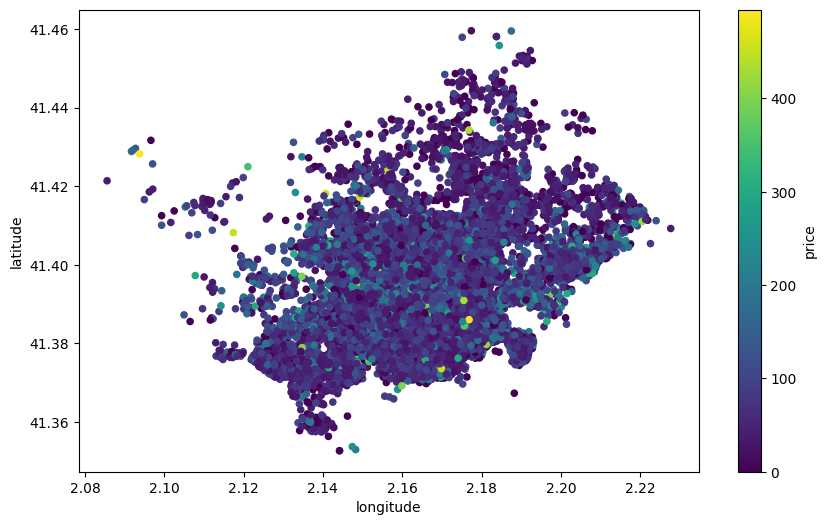

In [52]:
%%time
import pandas as pd
import matplotlib.pyplot as matp
airbnb_schema_pd = airbnb_schema.toPandas()
airbnb_schema_pd_trimmed = airbnb_schema_pd[airbnb_schema_pd['price'] < 500]
airbnb_schema_pd_trimmed.plot.scatter(x='longitude', y='latitude', c='price', cmap=matp.get_cmap('viridis'), figsize=(10,6))

Here is the total execution time of the notebook

In [53]:
%time
end_time = time.time()
print(f"Total execution time: {(end_time - start_time):.2f} seconds")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
Total execution time: 99.81 seconds
